In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
import joblib
import shap
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

# STATISTICS
from statsmodels.graphics.gofplots import qqplot

# HYPOTHESIS TESTING
from scipy.stats import ks_2samp
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# Sklearn preprocessing
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import AdaBoostRegressor,StackingRegressor,RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_approximation import Nystroem


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings("ignore", category=UserWarning)

SEED = 42

In [3]:
# Load data
train = pd.read_csv('data/train.csv',index_col=0)
test = pd.read_csv('data/test.csv',index_col=0)
sub = pd.read_csv('data/sample_submission.csv',index_col=0)

# Understanding Abalone Dataset Features

- Sex: This feature represents the gender of the abalone,categorized as male (M), female (F), or infant (I).

- Length: The length feature denotes the longest measurement of the abalone shell, from the apex to the base, measured in millimeters.

- Diameter: Diameter represents the measurement of the abalone shell perpendicular to its length, also measured in millimeters.

- Height: This feature signifies the height of the abalone shell, measured perpendicular to the plane formed by the length and diameter, in millimeters.

- Whole weight: Whole weight indicates the total weight of the abalone, encompassing both the meat and the shell, measured in grams.

- Whole weight.1 (Shucked weight): This feature represents the weight of the abalone meat only, measured in grams. It indicates the amount of meat extracted from the shell.

- Whole weight.2 (Viscera weight): Viscera weight signifies the weight of the abalone gut after bleeding, measured in grams.It provides insights into the weight of the internal organs of the abalone.

- Shell weight: This feature represents the weight of the abalone shell only, excluding the meat, measured in grams. It provides insights into the weight distribution between the shell and the edible portion of the abalone.

- Rings: Rings signify the number of rings present on the abalone shell, serving as an indicator of the abalone's age.

In [4]:
def rename_and_lowercase(df):
    """Rename columns and convert them to lowercase"""
    df = df.rename(columns = {'Whole weight.1':'shucked weight'})
    df = df.rename(columns = {'Whole weight.2':'viscera weight'})
    df = df.rename(columns=lambda x: x.lower().replace(' ', '_'))
    return df

train = rename_and_lowercase(train)
test = rename_and_lowercase(test)

train.columns, test.columns

(Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight', 'rings'],
       dtype='object'),
 Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight'],
       dtype='object'))

# 1 - EDA - Exploratory Analysis

## 1.1 - Summary Statistics

In [38]:
def generate_summary_statistics(data):
  
    summary_table = pd.DataFrame(data.dtypes, columns=['dtypes'])
    summary_table['Missing'] = data.isnull().sum()
    summary_table['Unique'] = data.nunique()
    summary_table['Count'] = data.count()
    summary_table['Duplicated'] = data.duplicated().sum()
    
    
    return summary_table

In [39]:
generate_summary_statistics(train)

,dtypes,Missing,Unique,Count,Duplicated
sex,object,0,3,90615,0
length,float64,0,157,90615,0
diameter,float64,0,126,90615,0
height,float64,0,90,90615,0
whole_weight,float64,0,3175,90615,0
shucked_weight,float64,0,1799,90615,0
viscera_weight,float64,0,979,90615,0
shell_weight,float64,0,1129,90615,0
rings,int64,0,28,90615,0


In [40]:
generate_summary_statistics(test)

,dtypes,Missing,Unique,Count,Duplicated
sex,object,0,3,60411,0
length,float64,0,148,60411,0
diameter,float64,0,130,60411,0
height,float64,0,85,60411,0
whole_weight,float64,0,3037,60411,0
shucked_weight,float64,0,1747,60411,0
viscera_weight,float64,0,960,60411,0
shell_weight,float64,0,1089,60411,0


Notes:
- No missing values or duplicated

## 1.2 - Univariate Analysis

In [45]:
# function to calculate univariate stats like pandas describe method
def univariate_stats(df):
    
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'IsNumeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    
    for col in df:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-' ]
    
    return output_df.sort_values(by=['IsNumeric', 'Unique'], ascending=False)

In [46]:
univariate_stats(train)

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
whole_weight,90615,0,3175,float64,True,0.5805,0.789035,0.002,0.419,0.7995,1.0675,2.8255,0.457671,0.429316,-0.185136
shucked_weight,90615,0,1799,float64,True,0.096,0.340778,0.001,0.1775,0.33,0.463,1.488,0.204428,0.591973,0.284012
shell_weight,90615,0,1129,float64,True,0.24,0.225898,0.0015,0.12,0.225,0.305,1.005,0.130203,0.479092,0.096049
viscera_weight,90615,0,979,float64,True,0.1715,0.169422,0.0005,0.0865,0.166,0.2325,0.76,0.100909,0.476733,-0.203721
length,90615,0,157,float64,True,0.575,0.517098,0.075,0.445,0.545,0.6,0.815,0.118217,-0.732015,0.133364
diameter,90615,0,126,float64,True,0.45,0.401679,0.055,0.345,0.425,0.47,0.65,0.098026,-0.695236,0.000646
height,90615,0,90,float64,True,0.15,0.135464,0.0,0.11,0.14,0.16,1.13,0.038008,0.309975,13.454051
rings,90615,0,28,int64,True,9,9.696794,1,8.0,9.0,11.0,29,3.176221,1.204273,2.612934
sex,90615,0,3,object,False,I,-,-,-,-,-,-,-,-,-


In [47]:
univariate_stats(test)

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
whole_weight,60411,0,3037,float64,True,0.5805,0.790062,0.002,0.4195,0.8015,1.07,2.8255,0.457591,0.435664,-0.165426
shucked_weight,60411,0,1747,float64,True,0.3485,0.341227,0.001,0.1785,0.329,0.4645,1.488,0.204221,0.593206,0.290172
shell_weight,60411,0,1089,float64,True,0.24,0.226125,0.0015,0.12,0.225,0.305,1.004,0.129826,0.468524,0.042671
viscera_weight,60411,0,960,float64,True,0.1715,0.169419,0.0005,0.0865,0.166,0.2325,0.6415,0.10072,0.476129,-0.204883
length,60411,0,148,float64,True,0.575,0.517428,0.075,0.45,0.545,0.6,0.8,0.117609,-0.734565,0.141789
diameter,60411,0,130,float64,True,0.45,0.401961,0.055,0.345,0.425,0.47,0.65,0.09747,-0.696312,0.004065
height,60411,0,85,float64,True,0.15,0.135751,0.0,0.11,0.14,0.16,1.095,0.038175,0.554506,17.693333
sex,60411,0,3,object,False,I,-,-,-,-,-,-,-,-,-


In [50]:
# list of numerical and categorical columns

numeric_cols = train.select_dtypes(exclude=['object']).columns.tolist()
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
target = 'rings'

numeric_cols, categorical_cols

(['length',
  'diameter',
  'height',
  'whole_weight',
  'shucked_weight',
  'viscera_weight',
  'shell_weight',
  'rings'],
 ['sex'])

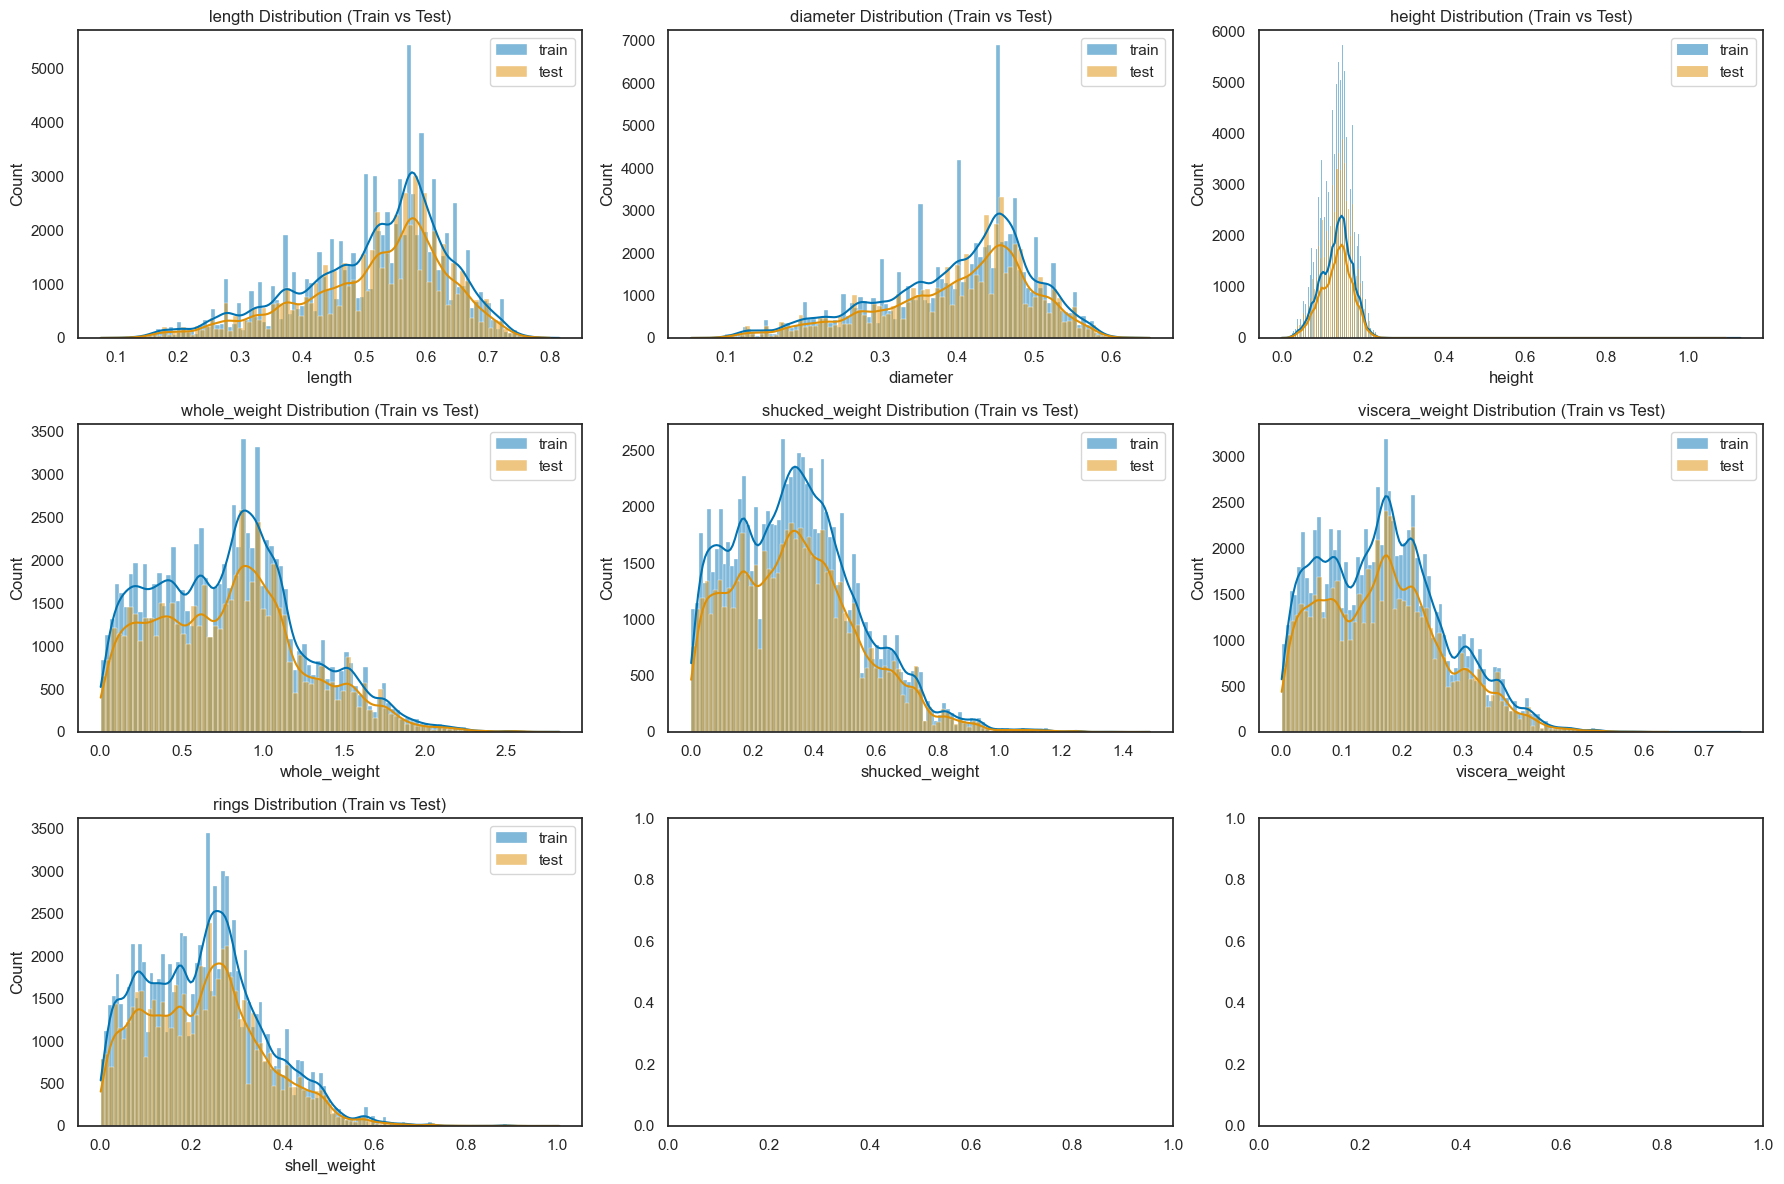

In [59]:
def plot_histograms(df_train, df_test, target_col, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))

    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        
        if var_name != target_col:
            ax = axes[i]
       
            # plot histogram for each variable in train
            sns.histplot(df_train[var_name], kde=True, ax=ax, label='train')

            # plot histogram for each variable in test
            sns.histplot(df_test[var_name], kde=True, ax=ax, label='test')

        
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_histograms(train[numeric_cols], test, target, n_cols=3)

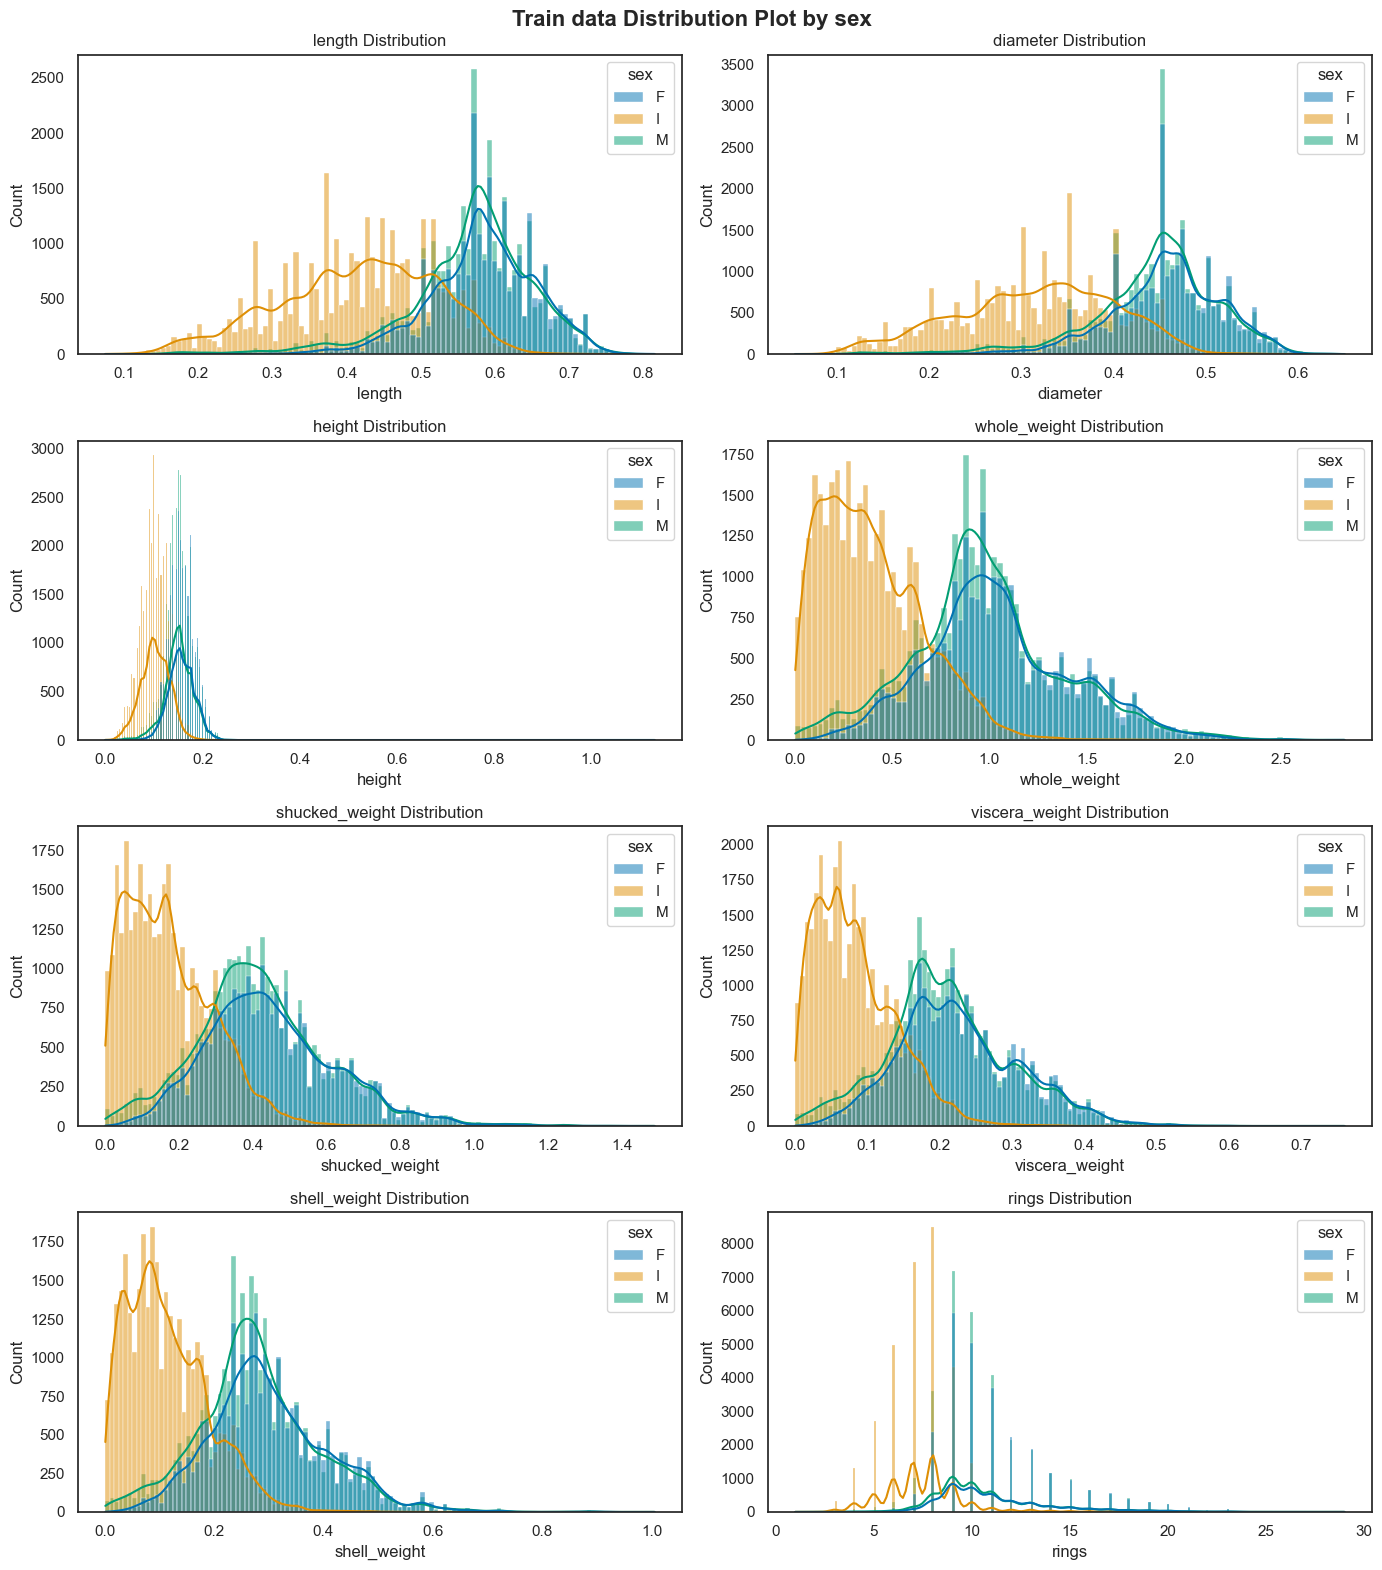

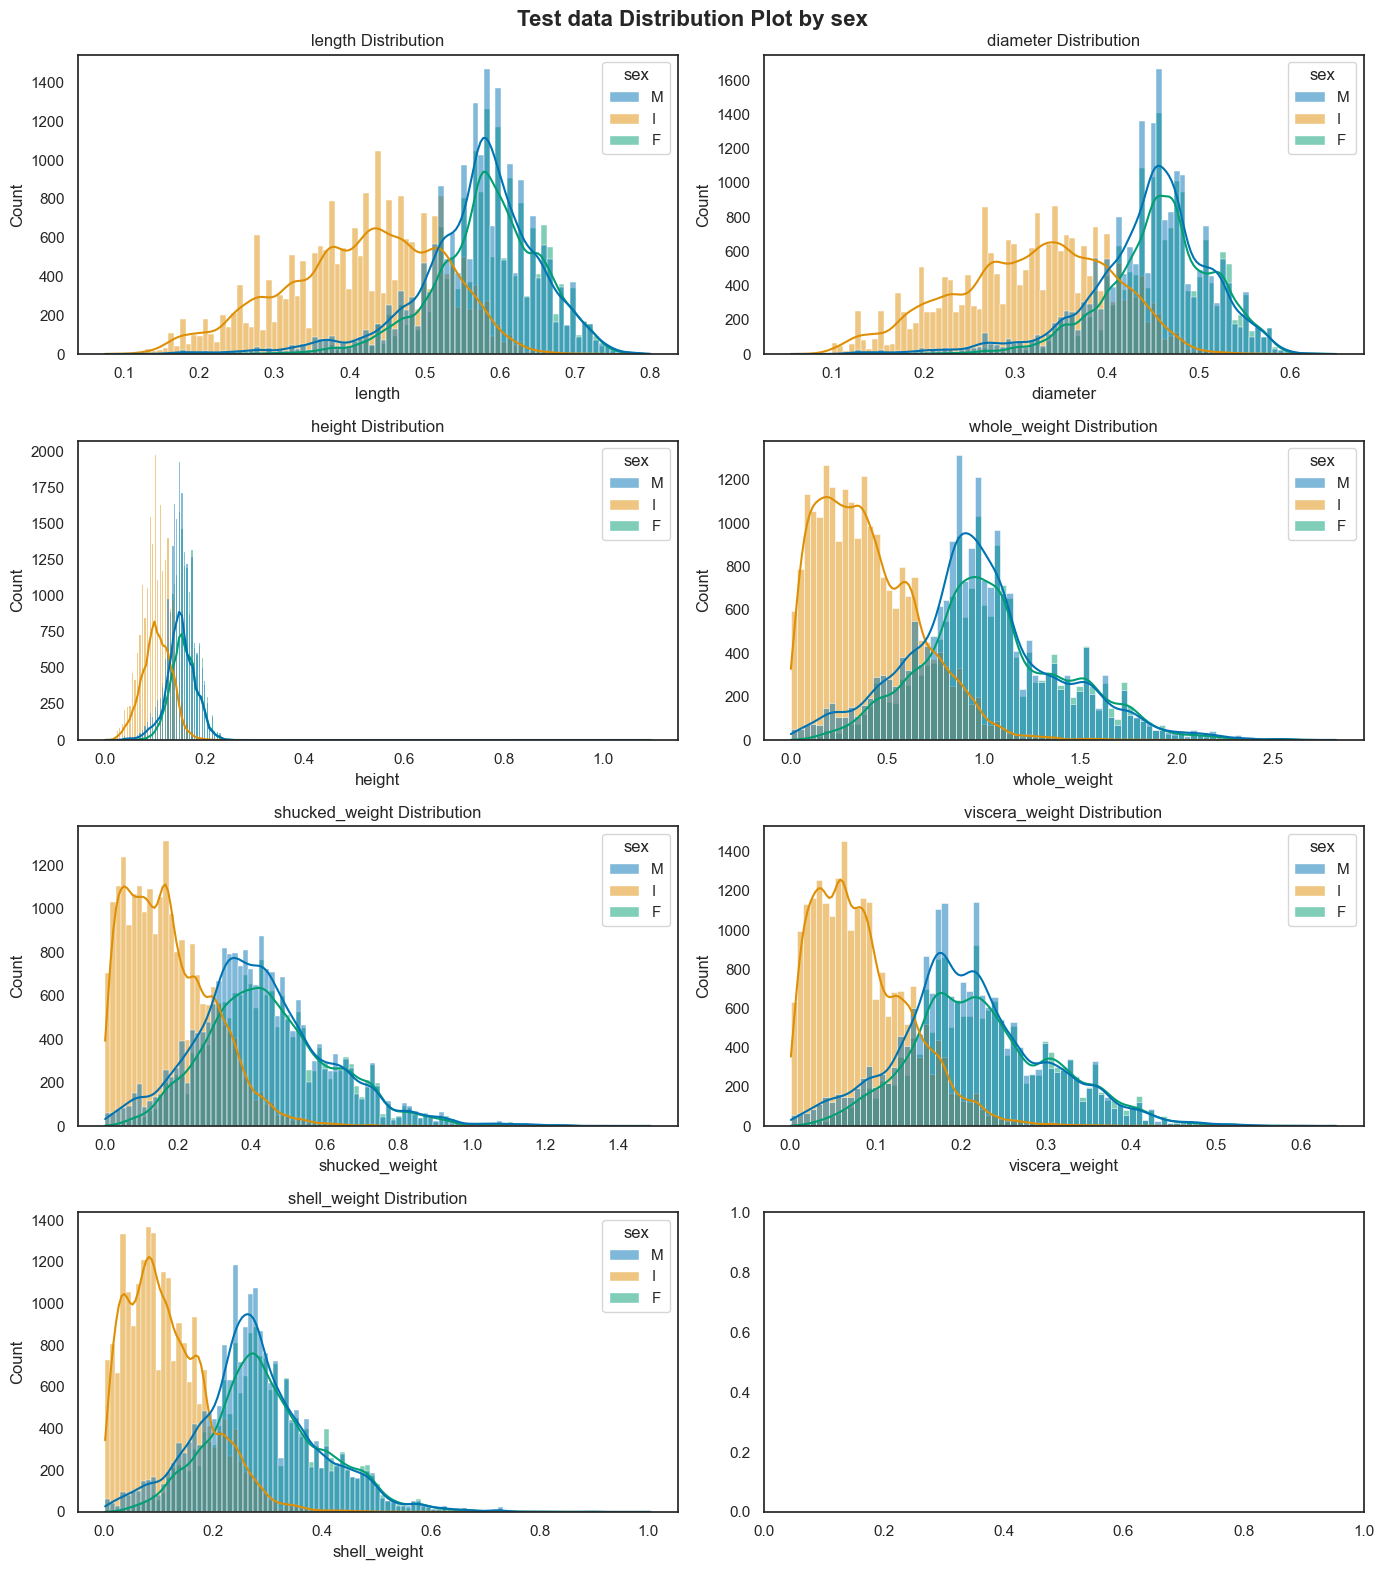

In [61]:
def plot_distributions(df, hue, title='', drop_cols=[]):
    
    cols = df.columns.drop([hue] + drop_cols)
    n_cols = 2
    n_rows = (len(cols) - 1) // n_cols + 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    
    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]
        sns.histplot(df, x=var_name, hue=hue, kde=True, ax=ax)
        ax.set_title(f'{var_name} Distribution')
    
    fig.suptitle(f'{title} Distribution Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_distributions(train,hue='sex', title='Train data')
plot_distributions(test,hue='sex', title='Test data')
    

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">
    
**Note:** 
<ul>
    <li>There is a big difference in distribution between I (infant) and adults (M or F). It almost like a binary variable, either is is infant or not</li>
    <li>Maybe test it feature engineering</li>
</ul>

</div>

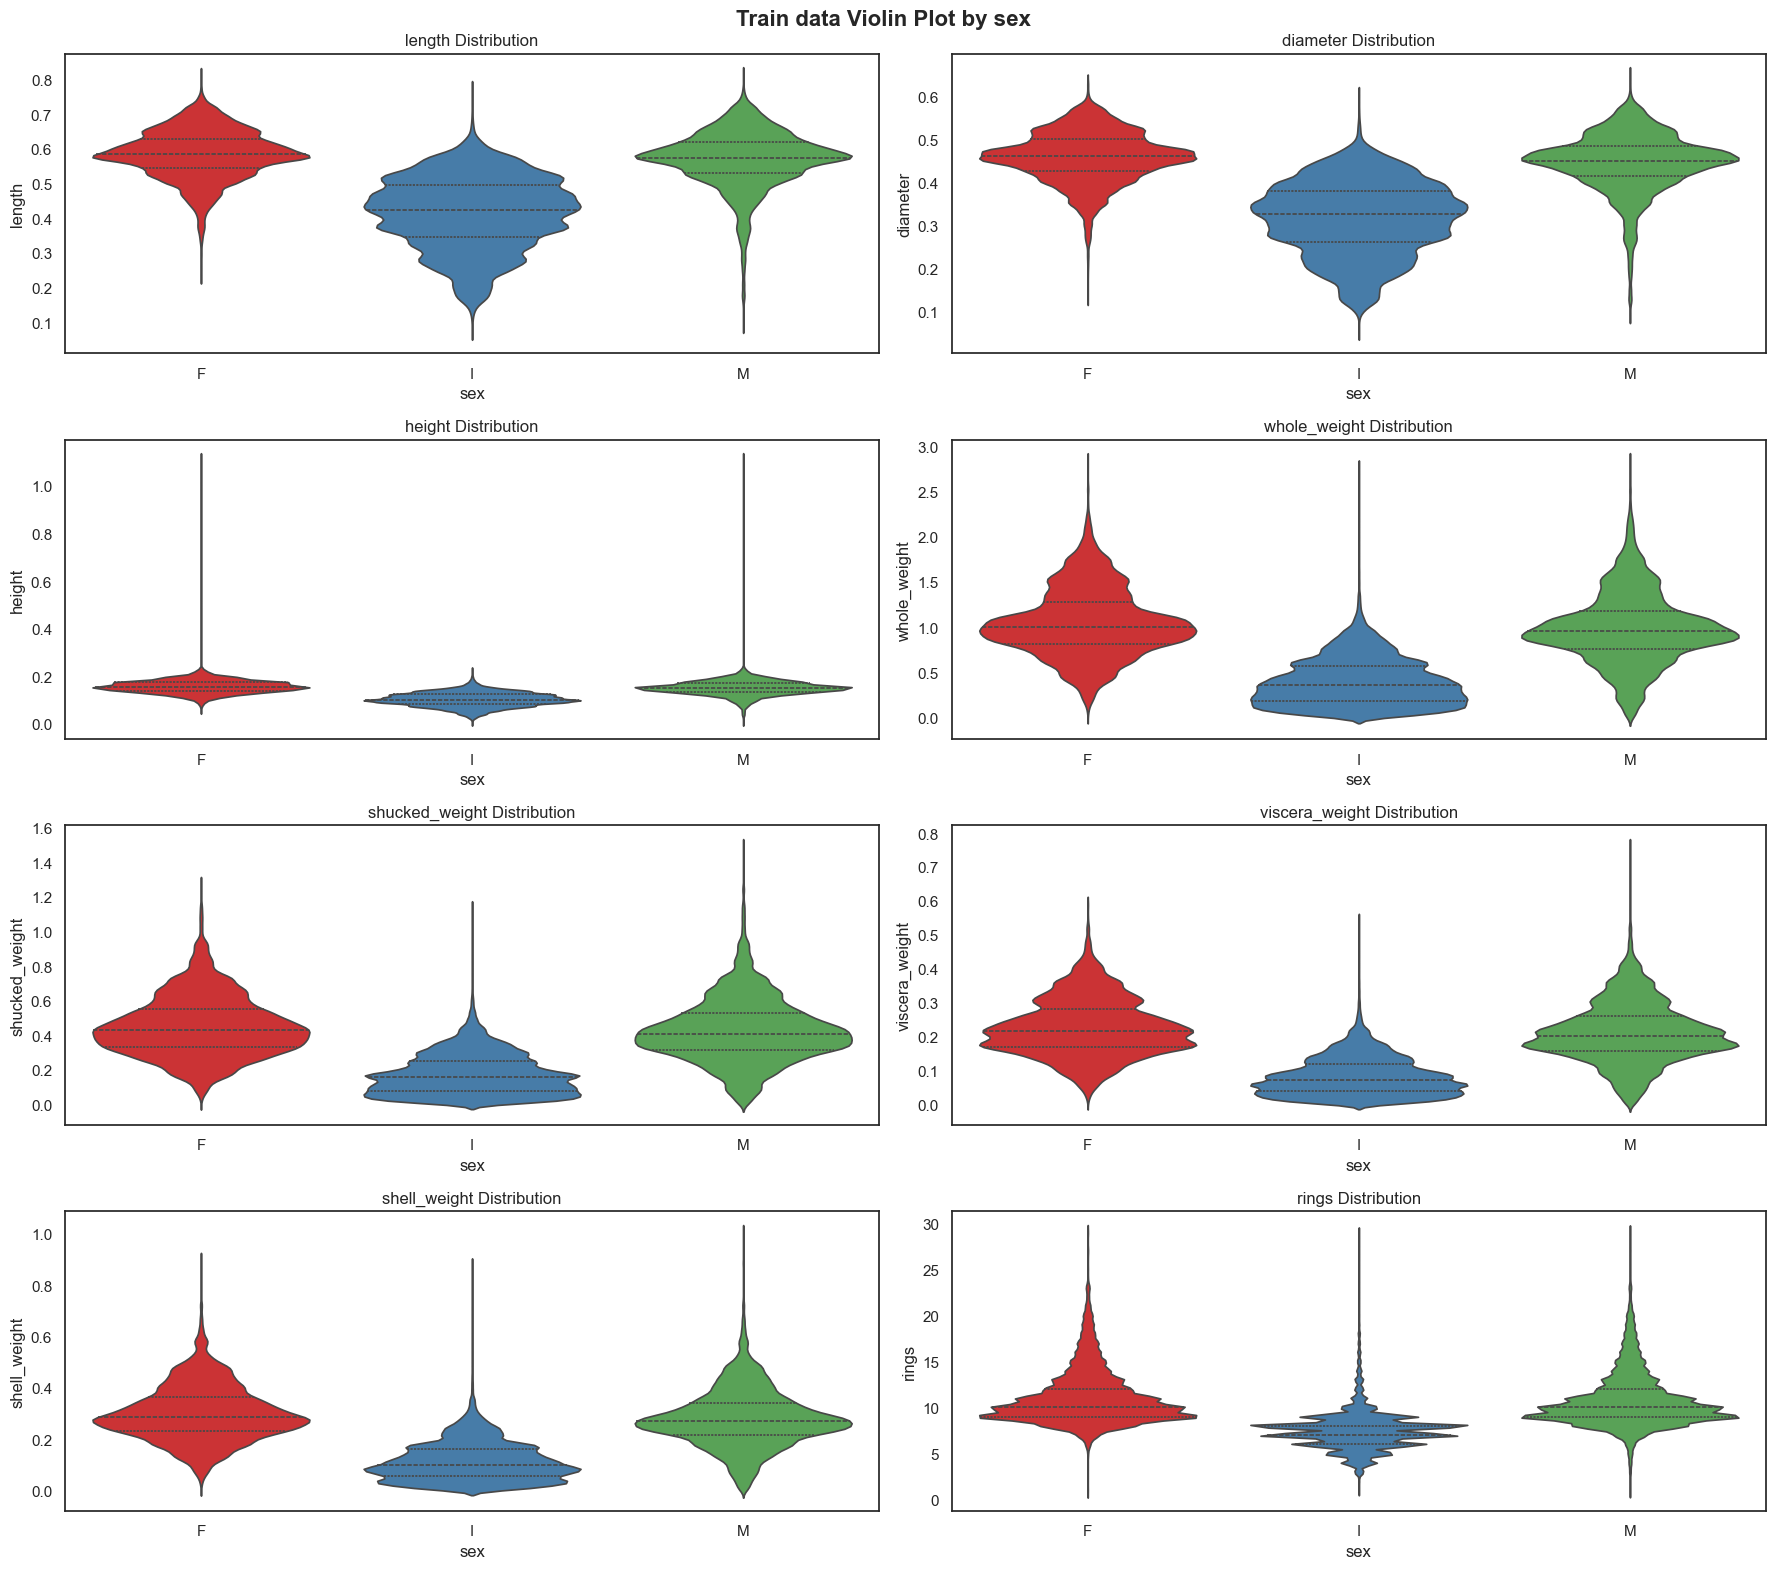

In [67]:
def plot_violinplot(df, hue, title='', drop_cols=[], n_cols=2):
    cols = df.columns.drop([hue] + drop_cols)
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4 * n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.violinplot(data=df, x=hue, y=var_name, ax=ax, inner='quartile', palette='Set1')  # Added palette parameter
        ax.set_title(f'{var_name} Distribution')

    fig.suptitle(f'{title} Violin Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_violinplot(train, hue='sex', title='Train data', n_cols=2)


<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">
    
**Note:** 
<p>Violin plots also confirm the difference between infants and adults</p>

</div>

In [76]:
train[numeric_cols]

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
id,,,,,,,,
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...
90610,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6


In [82]:
test

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
id,,,,,,,,
90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050
...,...,...,...,...,...,...,...,...
151021,I,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500
151022,F,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050
151023,I,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650


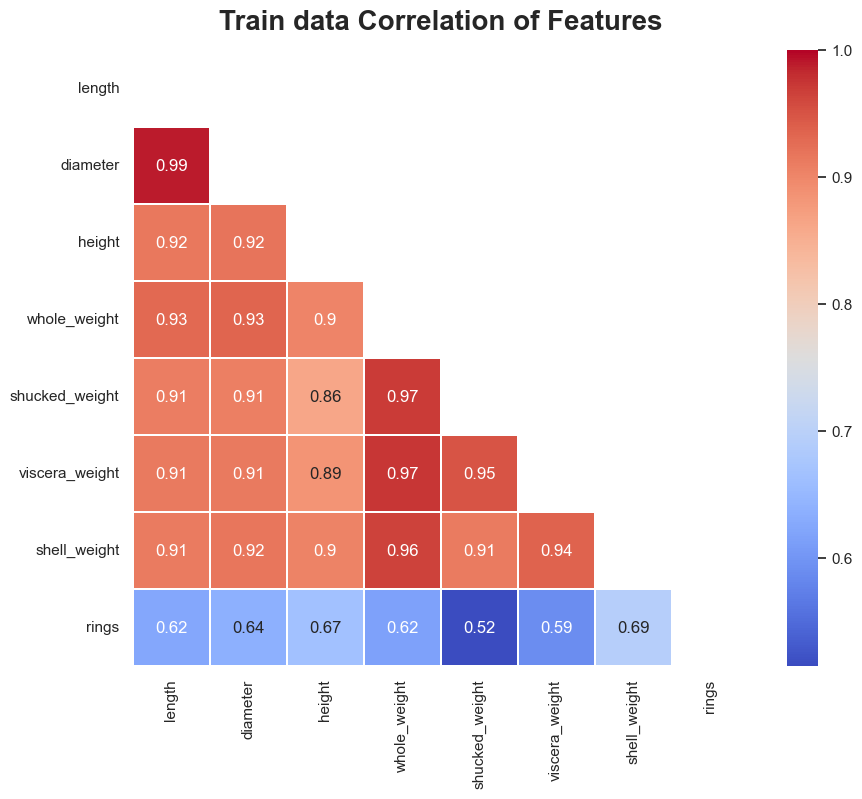

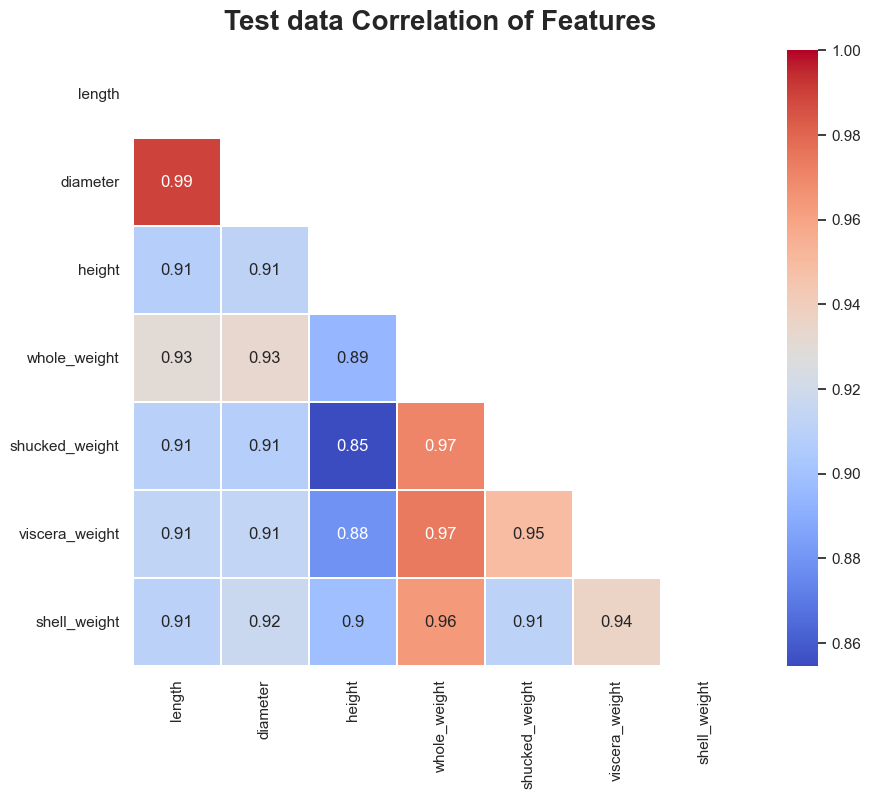

In [90]:
def plot_heatmap(df,title):
    
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True
    
    plt.figure(figsize=(10, 8))
    
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=20)
    
    sns.heatmap(df.astype(float).corr(),
                linewidths=0.1,
                vmax=1.0, 
                square=True, 
                cmap='coolwarm', 
                linecolor='white', 
                annot=True, 
                mask=mask)
    
plot_heatmap(train[numeric_cols], title='Train data')
plot_heatmap(test, title='Test data')

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

**Notes**

<p>When all features are highly correlated, it can lead to multicollinearity in your model, which can make the model's estimates very sensitive to changes in the model. Here are a few strategies to handle this situation</p>

<ul>  
    <li><b>Feature Selection:</b> You can manually select a subset of your features based on domain knowledge or based on the correlation matrix</li>
    <li><b>Dimensionality Reduction:</b> Techniques like Principal Component Analysis (PCA) can be used to reduce the dimensionality of your data. PCA creates new uncorrelated variables that successively maximize variance</li>
    <li><b>Regularization:</b> Use a model that includes a penalty term for complexity in the loss function, such as Lasso or Ridge regression. These models can help to avoid overfitting by penalizing large coefficients</li>
    <li><b>Variance Inflation Factor (VIF):</b> Calculate the VIF for each variable, which measures how much the variance of the estimated regression coefficients are increased because of multicollinearity. If VIF is high for a variable, consider dropping it</li>
    <li><b>Combine Features:</b> If it makes sense in the context of your problem, you can combine correlated features into a single feature (for example, by taking an average)</li>
</ul>

</div>

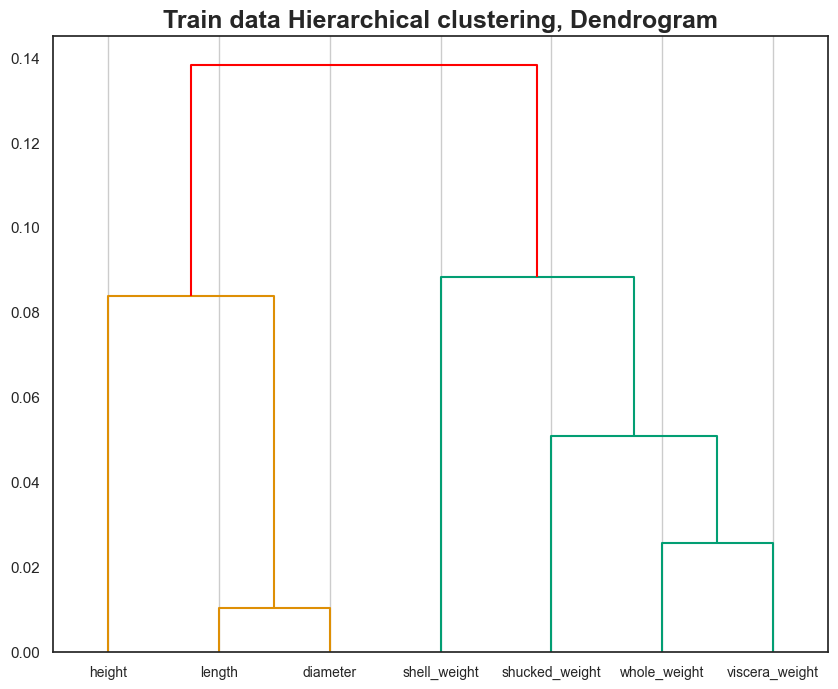

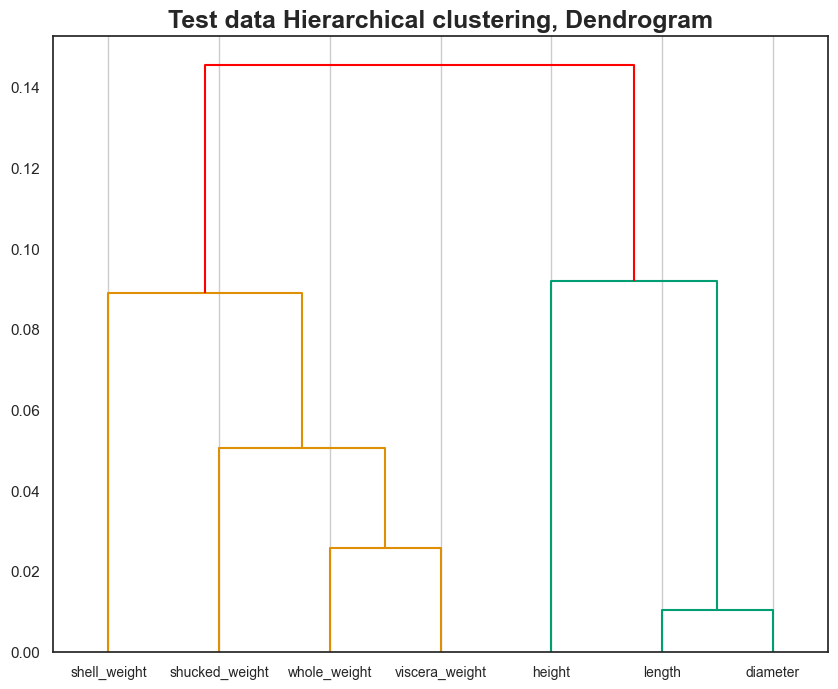

In [93]:
def hierarchical_clustering(data, title, drop_cols=[]):
    
    data = data.drop(drop_cols, axis=1, errors='ignore')
    
    fig, axis = plt.subplots(1,1,figsize=(10, 8),dpi=100)
    correlations = data.corr()
    coverted_corr = 1 - np.abs(correlations)
    Z = linkage(squareform(coverted_corr), method='complete')
    
    dn = dendrogram(Z, labels=data.columns, ax=axis, above_threshold_color='#ff0000', leaf_font_size=10) 
    hierarchy.set_link_color_palette(None)
    plt.grid(axis='x')
    plt.title(f'{title} Hierarchical clustering, Dendrogram', fontsize=18, fontweight='bold')
    plt.show()
    
hierarchical_clustering(train[numeric_cols], title='Train data', drop_cols='rings')
hierarchical_clustering(test, title='Test data')

<div style="background-color: #343A1A; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">

**Notes**

<p>A dendrogram is a diagram that shows the hierarchical relationship between objects. It is most commonly created as an output from hierarchical clustering. The main use of a dendrogram is to work out the best way to allocate objects to clusters</p>

<p>Observations are allocated to clusters by drawing a horizontal line through the dendrogram. Observations that are joined together below the line are in clusters</p>

<p>In the case, seems we have two clusters</p>
<ul>
    <li><b>weight cluster</b> -> shell + schuked + whole + viscera</li>
    <li><b>dimensions cluster</b> -> height + lenght + diameter</li>
<ul>

</div>